In [1]:
from gensim.models import Word2Vec, word2vec
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
from nltk.corpus import stopwords
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
import sqlite3
import re
from tqdm import tqdm

In [2]:
logging.basicConfig(level=logging.INFO)
get_ipython().magic('matplotlib inline')

In [3]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

LookupError: 
**********************************************************************
  Resource 'tokenizers/punkt/PY3/english.pickle' not found.
  Please use the NLTK Downloader to obtain the resource:  >>>
  nltk.download()
  Searched in:
    - '/home/dsxuser/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************

In [4]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> l

Packages:
  [ ] abc................. Australian Broadcasting Commission 2006
  [ ] alpino.............. Alpino Dutch Treebank
  [ ] averaged_perceptron_tagger Averaged Perceptron Tagger
  [ ] averaged_perceptron_tagger_ru Averaged Perceptron Tagger (Russian)
  [ ] basque_grammars..... Grammars for Basque
  [ ] biocreative_ppi..... BioCreAtIvE (Critical Assessment of Information
                           Extraction Systems in Biology)
  [ ] bllip_wsj_no_aux.... BLLIP Parser: WSJ Model
  [ ] book_grammars....... Grammars from NLTK Book
  [ ] brown............... Brown Corpus
  [ ] brown_tei........... Brown Corpus (TEI XML Version)
  [ ] cess_cat............ CESS-CAT Treebank
  [ ] cess_esp............ CESS-ESP Treebank
  [ ] chat80.....

True

In [5]:
# The code was removed by Watson Studio for sharing.

INFO:ibm_botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): s3-api.us-geo.objectstorage.service.networklayer.com


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
reviews = reviews[reviews.Score != 3]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f79f265c5f8>]], dtype=object)

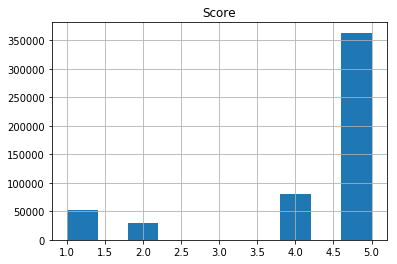

In [7]:
reviews.hist('Score')

In [8]:
reviews['Class'] = 1 * (reviews['Score'] > 3)

In [9]:
reviews.head(n=2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Class
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0


In [10]:
reviews.sort_values('ProductId', axis=0, inplace=True)

In [11]:
train_size = int(len(reviews) * 0.5)
train_reviews = reviews.iloc[:train_size,:]
test_reviews = reviews.iloc[train_size:,:]

In [12]:
test_remove = np.logical_or(test_reviews['ProductId'].isin(train_reviews['ProductId']),
                          test_reviews['UserId'].isin(train_reviews['UserId']))
test_reviews = test_reviews[np.logical_not(test_remove)]

In [13]:
print('Training set contains {:d} reviews.'.format(len(train_reviews)))
print('Test set contains {:d} reviews ({:d} removed).'.format(len(test_reviews), sum(test_remove)))

Training set contains 262907 reviews.
Test set contains 151198 reviews (111709 removed).


In [14]:
n_pos_train = sum(train_reviews['Class'] == 1)
print('Training set contains {:.2%} positive reviews'.format(n_pos_train/len(train_reviews)))
n_pos_test = sum(test_reviews['Class'] == 1)
print('Test set contains {:.2%} positive reviews'.format(n_pos_test/len(test_reviews)))

Training set contains 84.93% positive reviews
Test set contains 82.37% positive reviews


In [15]:
del reviews

In [16]:
def review_to_wordlist(review, remove_stopwords=False):
    """
    Convert a review to a list of words. Removal of stop words is optional.
    """
    # remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review)
    
    # convert to lower case and split at whitespace
    words = review_text.lower().split()
    
    # remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    return words

In [17]:
def review_to_sentences(review, tokenizer, remove_stopwords=False):
    """
    Split review into list of sentences where each sentence is a list of words.
    Removal of stop words is optional.
    """
    # use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())

    # each sentence is furthermore split into words
    sentences = []    
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            sentences.append(review_to_wordlist(raw_sentence, remove_stopwords))
            
    return sentences

In [18]:
train_sentences = []  # Initialize an empty list of sentences
for review in train_reviews['Text']:
    train_sentences += review_to_sentences(review, tokenizer)

NameError: name 'tokenizer' is not defined

In [19]:
train_sentences[0]

IndexError: list index out of range

In [20]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [21]:
train_sentences = []  # Initialize an empty list of sentences
for review in train_reviews['Text']:
    train_sentences += review_to_sentences(review, tokenizer)

In [22]:
train_sentences[0]

['this',
 'witty',
 'little',
 'book',
 'makes',
 'my',
 'son',
 'laugh',
 'at',
 'loud']

In [23]:
model_name = 'train_model'
# Set values for various word2vec parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 3       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-3   # Downsample setting for frequent words
if not os.path.exists(model_name): 
    # Initialize and train the model (this will take some time)
    model = word2vec.Word2Vec(train_sentences, workers=num_workers, \
                size=num_features, min_count = min_word_count, \
                window = context, sample = downsampling)

    # If you don't plan to train the model any further, calling 
    # init_sims will make the model much more memory-efficient.
    model.init_sims(replace=True)

    # It can be helpful to create a meaningful model name and 
    # save the model for later use. You can load it later using Word2Vec.load()
    model.save(model_name)
else:
    model = Word2Vec.load(model_name)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 180428 words, keeping 8069 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000, processed 359188 words, keeping 11891 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #30000, processed 524070 words, keeping 15515 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #40000, processed 680380 words, keeping 17879 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #50000, processed 842552 words, keeping 20707 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #60000, processed 1004577 words, keeping 22649 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #70000, processed 1167004 words, keeping 24754 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #80000, processed 1320862 words, keeping

In [24]:
del train_sentences

In [25]:
model.doesnt_match("banana apple orange sausage".split())

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  if __name__ == '__main__':


'sausage'

In [27]:
model.wv.doesnt_match("banana apple orange sausage".split())

'sausage'

In [28]:
model.wv.doesnt_match("vanilla chocolate cinnamon dish".split())

'dish'

In [29]:
model.most_similar("great")

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':


[('fantastic', 0.7866164445877075),
 ('terrific', 0.7834751605987549),
 ('wonderful', 0.7685626745223999),
 ('good', 0.7085849046707153),
 ('fabulous', 0.7068175673484802),
 ('awesome', 0.670752763748169),
 ('excellent', 0.6457017660140991),
 ('superb', 0.6306446194648743),
 ('perfect', 0.6197716593742371),
 ('amazing', 0.6015411615371704)]

In [30]:
model.wv.most_similar("awful")

[('terrible', 0.7386919856071472),
 ('horrible', 0.7337364554405212),
 ('disgusting', 0.6804637908935547),
 ('gross', 0.6639425754547119),
 ('aweful', 0.6588665246963501),
 ('nasty', 0.602871835231781),
 ('horrid', 0.6009899377822876),
 ('amazing', 0.5724624395370483),
 ('dreadful', 0.5691972970962524),
 ('awesome', 0.5685483813285828)]

In [31]:
model.wv.most_similar(positive=['woman', 'king'], negative=['man'])

[('charles', 0.5279216766357422),
 ('cavalier', 0.49235987663269043),
 ('spaniel', 0.4289575219154358),
 ('cocker', 0.4020504355430603),
 ('springer', 0.40188121795654297),
 ('arthur', 0.39694249629974365),
 ('breeder', 0.3966832756996155),
 ('md', 0.3817521035671234),
 ('jake', 0.37769854068756104),
 ('spaniels', 0.37650030851364136)]

In [32]:
model.wv.similar_by_vector(model['beer'] - model['alcohol'])

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


[('beer', 0.6428319215774536),
 ('sushi', 0.312652051448822),
 ('diner', 0.30898433923721313),
 ('style', 0.3053444027900696),
 ('enchiladas', 0.3039426803588867),
 ('grandmother', 0.29402580857276917),
 ('burritos', 0.2922184467315674),
 ('grandma', 0.28205499053001404),
 ('boyardee', 0.28004831075668335),
 ('tortillas', 0.27907007932662964)]

In [34]:
model.wv.syn0.shape

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  if __name__ == '__main__':


(10821, 300)

In [42]:
def make_feature_vec(words, model, num_features):
    """
    Average the word vectors for a set of words
    """
    feature_vec = np.zeros((num_features,),dtype="float32")  # pre-initialize (for speed)
    nwords = 0.
    index2word_set = set(model.wv.index2word)  # words known to the model

    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            feature_vec = np.add(feature_vec,model[word])
    
    feature_vec = np.divide(feature_vec, nwords)
    return feature_vec


def get_avg_feature_vecs(reviews, model, num_features):
    """
    Calculate average feature vectors for all reviews
    """
    counter = 0.
    review_feature_vecs = np.zeros((len(reviews),num_features), dtype='float32')  # pre-initialize (for speed)
    
    for review in reviews:
        review_feature_vecs[counter] = make_feature_vec(review, model, num_features)
        counter = counter + 1.
    return review_feature_vecs

In [43]:
# calculate average feature vectors for training and test sets
clean_train_reviews = []
for review in train_reviews['Text']:
    clean_train_reviews.append(review_to_wordlist(review, remove_stopwords=True))
trainDataVecs = get_avg_feature_vecs(clean_train_reviews, model, num_features)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [37]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> corpora
    Error loading corpora: Package 'corpora' not found in index

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> l

Packages:
  [ ] abc................. Australian Broadcasting Commission 2006
  [ ] alpino.............. Alpino Dutch Treebank
  [ ] averaged_perceptron_tagger Averaged Perceptron Tagger
  [ ] averaged_perceptron_tagger_ru Averaged Perceptron Tagger (Russian)
  [ ] basque_grammars..... Grammars for Basque
  [ ] biocreative_ppi..... BioCreAtIvE (Critical Assessment of Informati

True

In [ ]:
clean_test_reviews = []
for review in test_reviews['Text']:
    clean_test_reviews.append(review_to_wordlist(review, remove_stopwords=True))
testDataVecs = get_avg_feature_vecs(clean_test_reviews, model, num_features)

In [ ]:
# Fit a random forest to the training data, using 100 trees
forest = RandomForestClassifier(n_estimators = 100)

print("Fitting a random forest to labeled training data...")
forest = forest.fit(trainDataVecs, train_reviews['Class'])

In [ ]:
# remove instances in test set that could not be represented as feature vectors
nan_indices = list({x for x,y in np.argwhere(np.isnan(testDataVecs))})
if len(nan_indices) > 0:
    print('Removing {:d} instances from test set.'.format(len(nan_indices)))
    testDataVecs = np.delete(testDataVecs, nan_indices, axis=0)
    test_reviews.drop(test_reviews.iloc[nan_indices, :].index, axis=0, inplace=True)
    assert testDataVecs.shape[0] == len(test_reviews)

In [ ]:
print("Predicting labels for test data..")
result = forest.predict(testDataVecs)

In [ ]:
print(classification_report(test_reviews['Class'], result))